CMPE 258 Assignment #4
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 03/17/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [125]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import tensorflow as tf

# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/HW4'
DATA_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/data'

# Where to save the figures
IMAGE_FOLD = 'images'
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, IMAGE_FOLD)

def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(IMAGE_DIR):
        os.makedirs(IMAGE_DIR)
    path = os.path.join(IMAGE_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
# test tensorflow
hello = tf.constant('Hello, TensorFlow!')
with tf.Session() as sess:
    print sess.run(hello)
sess.close()

Hello, TensorFlow!


1. (40pts) Define functions: All the functions are in class MLP_TF_TU, except onehot


In [130]:
def to_onehot(y, n_class):
    num = len(y)
    y_onehot = np.zeros((num, n_class), dtype=np.uint8)
    for i in range(num):
        y_onehot[i][y[i]] = 1
    return y_onehot

In [226]:
class MLP_TF_TU(object):
    
    def xavier_init(self, size_1, size_2):
        rand = tf.random_uniform([size_1, size_2], minval=0, maxval=1)
        param = pow(2.0 / (self.n_input + self.n_classes), 0.5)
        return tf.Variable(tf.multiply(param, rand), dtype=tf.float32)
    
    def __init__(self, size=(), lr=1e-3, epoch=10, batch=64, printstep=1, lamda=1e-3, drop=0.1, act='relu'):
        
        # Network Parameter Settings
        self.n_input = size[0]           # Input size (20 * 20)
        self.n_hidden_1 = size[1]        # 1st hidden layer number of neurons
        self.n_hidden_2 = size[2]        # 2nd hidden layer number of neurons
        self.n_classes = size[3]         # Output size 
     
        # Training Parameters
        self.learning_rate = lr
        self.epoch = epoch
        self.batch_size = batch
        self.print_step = printstep
        self.lamda = lamda      
        self.num_iter_per_epoch = int(np.ceil(X_train.shape[0] / batch))     # round up
        
        self.X = tf.placeholder(tf.float32, [None, self.n_input], name='X')
        self.Y = tf.placeholder(tf.float32, [None, self.n_classes], name='Y')
        self.keep_prob = tf.placeholder(tf.float32)
        self.keep_prob_val = 1.0 - drop
        
        # History record
        self.hasVal = False
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = [] 
        self.test_acc = 0.0
        
        # Weight & bias Initialization
        self.weights = {
            'W1': self.xavier_init(self.n_input, self.n_hidden_1),
            'W2': self.xavier_init(self.n_hidden_1, self.n_hidden_2),
            'W3': self.xavier_init(self.n_hidden_2, self.n_classes)
        }
        
        self.biases = {
            'b1': tf.Variable(tf.zeros([self.n_hidden_1]), dtype=tf.float32),
            'b2': tf.Variable(tf.zeros([self.n_hidden_2]), dtype=tf.float32),
            'b3': tf.Variable(tf.zeros([self.n_classes]), dtype=tf.float32)
        }
        
        # activation
        activation_dict = {'sigmoid': tf.nn.sigmoid, 'relu': tf.nn.relu, 'elu': tf.nn.elu}
        self.act = activation_dict[act.lower()]
        
    #############################################################
    #                       Define The DataFlow                 #
    #############################################################

    def dataFlow(self):
        
        # Create model
        def forward_prop(x):
            # Hidden Layer 1
            Z1 = tf.add(tf.matmul(x, self.weights['W1']), self.biases['b1'])
            N1 = tf.nn.batch_normalization(x=Z1, mean=0, variance=1e-2, variance_epsilon=1e-16, 
                                           offset=None, scale=None)
            A1 = self.act(N1)
            D1 = tf.nn.dropout(A1, keep_prob=self.keep_prob, seed=state)
            
            # Hidden Layer 2
            Z2 = tf.add(tf.matmul(D1, self.weights['W2']), self.biases['b2'])
            N2 = tf.nn.batch_normalization(x=Z2, mean=0, variance=1e-2, variance_epsilon=1e-16, 
                                           offset=None, scale=None)
            A2 = self.act(N2)
            D2 = tf.nn.dropout(A2, keep_prob=self.keep_prob, seed=state)
            # Output Layer
            Z_out = tf.add(tf.matmul(D2, self.weights['W3']), self.biases['b3'])
            return Z_out
        
        # Construct model
        self.logits = forward_prop(self.X)
        
        # Define loss and optimizer
        loss_data = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        loss_reg = tf.nn.l2_loss(self.weights['W1']) + tf.nn.l2_loss(self.weights['W2']) + \
                   tf.nn.l2_loss(self.weights['W3'])
        self.loss_op = tf.reduce_mean(loss_data + self.lamda * loss_reg)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, 
                                           beta2=0.999, epsilon=1e-08)
        self.train_op = optimizer.minimize(self.loss_op)
        
        score = tf.nn.softmax(self.logits)  # Apply softmax to logits
        pred = tf.equal(tf.argmax(score, 1), tf.argmax(self.Y, 1))
        
        self.train_acc = tf.reduce_mean(tf.cast(pred, tf.float32))
        self.val_acc = tf.reduce_mean(tf.cast(pred, tf.float32))
        self.test_acc = tf.reduce_mean(tf.cast(pred, tf.float32))

    #############################################################
    #                       Training Process                    #
    #############################################################
        
    def train(self, X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None, verbose=True):
        
        if X_val is not None:
            self.hasVal = True
            
        self.dataFlow()
        
        # Initializing the variables
        init = tf.global_variables_initializer()   
        
        with tf.Session() as sess:
            sess.run(init)
        
            # Training cycle
            for epoch in range(self.epoch):
                
                start_index = 0
                # Loop over all batches
                for i in range(self.num_iter_per_epoch):
                    if i == self.num_iter_per_epoch - 1:
                        X_bacth = X_train[start_index:]
                        y_batch = y_train[start_index:]
                    else:    
                        X_bacth = X_train[start_index:start_index + self.batch_size]
                        y_batch = y_train[start_index:start_index + self.batch_size]
                    start_index += self.batch_size
                    # Run optimization op (backprop) and cost op (to get loss value)
                    _, train_loss, train_acc = sess.run([self.train_op, self.loss_op, self.train_acc], 
                        feed_dict={self.X: X_bacth, self.Y: y_batch, self.keep_prob: self.keep_prob_val})
                    if self.hasVal:
                        val_acc = sess.run(self.val_acc, feed_dict={self.X: X_val, self.Y: y_val, 
                                                                self.keep_prob: self.keep_prob_val})
                self.loss_history.append(train_loss)
                self.train_acc_history.append(train_acc)
                if self.hasVal:
                    self.val_acc_history.append(val_acc)
                
                # control verbose
                if (epoch + 1) % self.print_step == 0 and self.hasVal and verbose:
                    print ('iteration %d / %d:   loss %.6f   train_acc %.6f   val_acc %.6f' % 
                           (epoch+1, self.epoch, train_loss, train_acc, val_acc))
                elif (epoch + 1) % self.print_step == 0 and X_test is not None and verbose:
                    print ('iteration %d / %d:   loss %.6f   train_acc %.6f' % 
                           (epoch+1, self.epoch, train_loss, train_acc))    
                    
            if X_test is not None:
                self.test_acc = sess.run(self.val_acc, feed_dict={self.X: X_test, self.Y: y_test, 
                                                        self.keep_prob: self.keep_prob_val})
                if verbose:
                    print 'Final Test Accuracy: %.6f' % self.test_acc
                
        sess.close()
        
    #############################################################
    #                Plot Loss, train_acc & val_acc             #
    #############################################################
    
    def plot_loss_acc(self):
        plt.figure(figsize=(18, 6))
        
        # plot loss vs. epoch
        plt.subplot(121)
        plt.plot(np.arange(1, len(self.loss_history) + 1), self.loss_history, 'r-', 
         label='learning rate ' + str(self.learning_rate))
        plt.xlabel('epoch')
        plt.ylabel('train loss')
        plt.legend(loc='upper right')
        plt.title('train loss vs. epoch')
        
        # plot train_acc & val_acc vs. epoch
        plt.subplot(122)
        plt.plot(np.arange(1, len(self.loss_history) + 1), self.train_acc_history, 'b-', 
                 label='train_acc')
        if self.hasVal:
            plt.plot(np.arange(1, len(self.loss_history) + 1), self.val_acc_history, 'g-', 
                     label='val_acc')
        plt.xlabel('epoch')
        plt.ylabel('train & val accuracy')
        plt.legend(loc='lower right')
        plt.title('train_acc & val_acc vs. epoch')
                                       

2.Load Data, split Train & Validation, normalization, and visulization


In [110]:
train_set = pd.read_csv(DATA_DIR + '/ex4_train.csv')
test_set = pd.read_csv(DATA_DIR + '/ex4_test.csv')
train_set.shape, test_set.shape

((3500, 402), (1500, 402))

In [53]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Columns: 402 entries, Unnamed: 0 to y
dtypes: float64(395), int64(7)
memory usage: 10.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 402 entries, Unnamed: 0 to y
dtypes: float64(395), int64(7)
memory usage: 4.6 MB


(None, None)

In [111]:
train_set.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,391,392,393,394,395,396,397,398,399,y
0,2240,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
1,4253,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8
2,4263,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8
3,57,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,4788,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9


In [112]:
# get rid of first column
X_train_all = train_set.iloc[:, 1:-1].values.astype('float32')
y_train_all = train_set['y'].values.astype('int32')
X_test = test_set.iloc[:, 1:-1].values.astype('float32')
y_test = test_set['y'].values.astype('int32')

X_train_all.shape, y_train_all.shape, X_test.shape, y_test.shape

((3500, 400), (3500,), (1500, 400), (1500,))

Normalize the data: zero center (shift) and scale

In [113]:
def Normalization(X):
    mean = np.mean(X, axis=0)
    max = np.max(X, axis=0)
    min = np.min(X, axis=0)     
    X = (X - mean) / (max - min + 1e-16)
    mean = np.mean(X, axis=0).sum()/X.shape[1]
    var = np.var(X, axis=0).sum()/X.shape[1]
    return X, mean, var


X_train_all, mean_1, var_1 = Normalization(X_train_all)
X_test, mean_2, var_2 = Normalization(X_test)
print 'train set:' '\nmean: ', mean_1, '\nvar: ', var_1
print 'test set:', '\nmean: ', mean_2, '\nvar: ', var_2

train set:
mean:  -1.5394494567999573e-10 
var:  0.04434843063354492
test set: 
mean:  1.5081218052159785e-10 
var:  0.045647101402282717


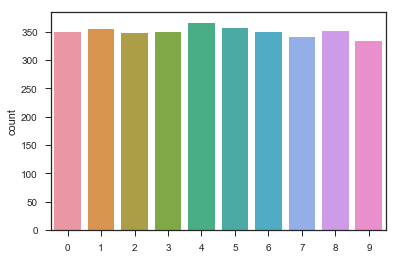

In [115]:
sns.countplot(y_train_all.ravel())

('label: ', 8)


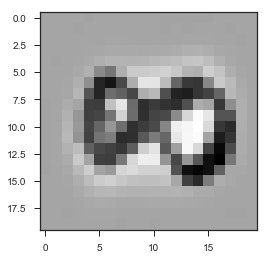

In [116]:
some_digit = X_train_all[1]
some_digit_image = some_digit.reshape(20, 20)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
print('label: ', y_train_all[1])

In [117]:
y_train_all = to_onehot(y_train_all, 10)
y_test = to_onehot(y_test, 10)
y_train_all = y_train_all.astype('float32')
y_test = y_test.astype('float32')
y_train_all.shape, y_test.shape

((3500, 10), (1500, 10))

In [118]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train_all, y_train_all, 0.8, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2800, 400), (700, 400), (2800, 10), (700, 10))

The following codes contains all required for question 3 - 6

Create a baseline for optimization:
1. Net Size: (400, 120, 40, 10)
2. Activation: ReLu
3. Regularization: 0
4. Mini-Batch Size: 64
5. Learning Rate: 1e-3
6. drop out 0.0

In [146]:
mlp_base = MLP_TF_TU(size=(400, 120, 40, 10), lr=1e-3, epoch=50, batch=64, printstep=10, 
                lamda=0, drop=0, act='relu')
mlp_base.train(X_train, y_train, X_val, y_val)

iteration 10 / 50:   loss 0.133214   train_acc 0.955357   val_acc 0.937143


iteration 20 / 50:   loss 0.077215   train_acc 0.991071   val_acc 0.921429


iteration 30 / 50:   loss 0.006989   train_acc 1.000000   val_acc 0.935714


iteration 40 / 50:   loss 0.002967   train_acc 1.000000   val_acc 0.940000


iteration 50 / 50:   loss 0.001648   train_acc 1.000000   val_acc 0.940000


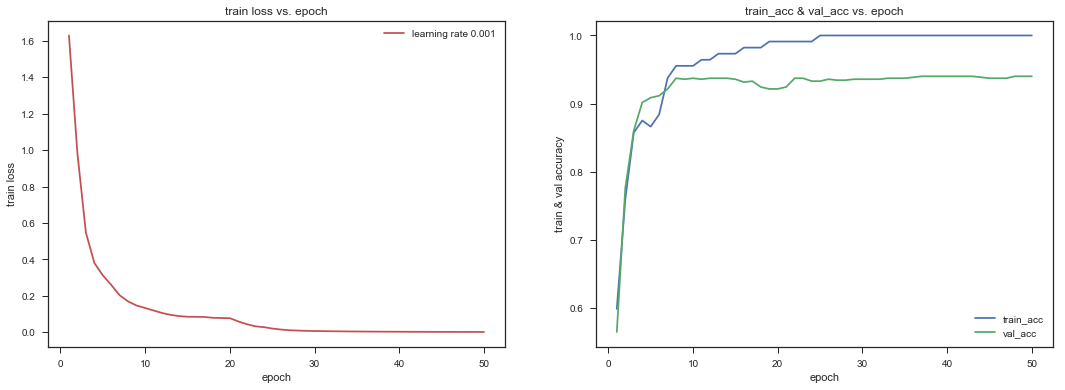

In [147]:
mlp_base.plot_loss_acc()

Baseline validation accuracy: 0.94

optimization 1: 2-hidden MLP Hidden layer neuron numbers
1. (400, 120, 40, 10)
2. (400, 120, 120, 10)
3. (400, 40, 40, 10)
4. (400, 256, 32, 10)

In [141]:
size = [(400, 120, 40, 10), (400, 120, 120, 10), (400, 40, 40, 10), (400, 256, 32, 10)]
for i in range(len(size)): 
    mlp_archi = MLP_TF_TU(size=size[i], lr=1e-3, epoch=100, batch=64, printstep=10, 
                lamda=0, drop=0, act='relu')
    mlp_archi.train(X_train, y_train, X_val, y_val, verbose=False)
    print 'net archi: ', size[i], ' val_acc: ', mlp_archi.val_acc_history[-1]

net archi:  (400, 120, 40, 10)  val_acc:  0.9414285


net archi:  (400, 120, 120, 10)  val_acc:  0.9342857


net archi:  (400, 40, 40, 10)  val_acc:  0.9357143


net archi:  (400, 256, 32, 10)  val_acc:  0.93999994


I will still choose (400, 120, 40, 10)

optimization 2: Activation Functions
1. ReLu
2. Elu

In [159]:
# it takes some time
activation = ['relu', 'elu']
lr = [3e-3, 1e-3, 3e-4]
epoch = [50, 100, 150]

for i in range(len(activation)): 
    val_acc = 0.0
    for j in range(len(lr)):
        mlp_act = MLP_TF_TU(size=(400, 120, 40, 10), lr=lr[j], epoch=epoch[j], batch=64, printstep=10, 
                    lamda=0, drop=0, act=activation[i])
        mlp_act.train(X_train, y_train, X_val, y_val, verbose=False)
        val_acc += mlp_act.val_acc_history[-1]
    mean_val_acc = val_acc / len(lr)
    print 'activation: ', activation[i], ' mean val_acc: ', mean_val_acc

activation:  relu  mean val_acc:  0.9347618619600931


activation:  elu  mean val_acc:  0.942380944887797


I will choose Elu as Activation Function

optimization 3: L2 Regularization
1. 10 values in range(1e-5, 1e-1)

In [209]:
reg = np.logspace(-5, -1, 10)
val_acc = []
for i in range(len(reg)): 
    mlp_reg = MLP_TF_TU(size=(400, 120, 40, 10), lr=1e-3, epoch=50, batch=64, printstep=10, 
                lamda=reg[i], drop=0, act='elu')
    mlp_reg.train(X_train, y_train, X_val, y_val, verbose=False)
    val_acc.append(mlp_reg.val_acc_history[-1])
    print 'L2 lamda: ', reg[i], ' val_acc: ', mlp_reg.val_acc_history[-1]

L2 lamda:  1e-05  val_acc:  0.9399999


L2 lamda:  2.782559402207126e-05  val_acc:  0.9471428


L2 lamda:  7.742636826811278e-05  val_acc:  0.9514286


L2 lamda:  0.00021544346900318823  val_acc:  0.93999994


L2 lamda:  0.0005994842503189409  val_acc:  0.93999994


L2 lamda:  0.0016681005372000592  val_acc:  0.94571424


L2 lamda:  0.004641588833612777  val_acc:  0.9199999


L2 lamda:  0.012915496650148827  val_acc:  0.94285715


L2 lamda:  0.03593813663804626  val_acc:  0.9514285


L2 lamda:  0.1  val_acc:  0.94142854


Text(0.5,1,u'Lamda vs. Val_acc')

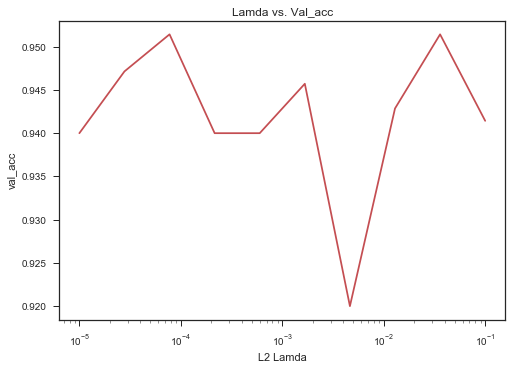

In [210]:
plt.semilogx(reg, val_acc, 'r-')
plt.xlabel('L2 Lamda')
plt.ylabel('val_acc')
plt.title('Lamda vs. Val_acc')

After more specific test in range(1e-2, 1e-1), according to the validation acc, I will choose L2 lamda 1e-2

I changed batch size to 256 since when batch size is small, for bigger L2 Lamda values, the training will be noisy and unstable

Final Model Without Dropout
1. Net Size: (400, 120, 40, 10)
2. Activation: Elu
3. Regularization: 1e-2
4. Mini-Batch Size: 256
5. Learning Rate: 1e-3
6. drop out 0.0

In [222]:
mlp_final_nodrop = MLP_TF_TU(size=(400, 120, 40, 10), lr=1e-3, epoch=1000, batch=256, printstep=100, 
                lamda=1e-2, drop=0, act='elu')
mlp_final_nodrop.train(X_train_all, y_train_all, X_test=X_test, y_test=y_test)

iteration 100 / 1000:   loss 0.181713   train_acc 0.985786


iteration 200 / 1000:   loss 0.121603   train_acc 0.995819


iteration 300 / 1000:   loss 0.126017   train_acc 0.988294


iteration 400 / 1000:   loss 0.129865   train_acc 0.979097


iteration 500 / 1000:   loss 0.073233   train_acc 0.999164


iteration 600 / 1000:   loss 0.083661   train_acc 0.989967


iteration 700 / 1000:   loss 0.071477   train_acc 1.000000


iteration 800 / 1000:   loss 0.059380   train_acc 1.000000


iteration 900 / 1000:   loss 0.057627   train_acc 1.000000


iteration 1000 / 1000:   loss 0.057493   train_acc 1.000000


Final Test Accuracy: 0.952000


The Final Model Without dropout got test accuracy: 0.952

Optimization 4: Dropout, 
1. Test 7 values: (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6)
2. use a large training epoch to make sure the training fully converged, because when drop out is big, it needs more epochs to train

In [227]:
drop = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
test_acc = []
for i in range(len(drop)):
    mlp_drop = MLP_TF_TU(size=(400, 120, 40, 10), lr=1e-3, epoch=1500, batch=256, printstep=150, 
                    lamda=1e-2, drop=drop[i], act='elu')
    mlp_drop.train(X_train_all, y_train_all, X_test=X_test, y_test=y_test, verbose=False)
    test_acc.append(mlp_drop.test_acc)
    print 'Drop out: ', drop[i], '  Test Accuracy: ', mlp_drop.test_acc

Final Test Accuracy: 0.952667


Drop out:  0   Test Accuracy:  0.95266664


Final Test Accuracy: 0.938000


Drop out:  0.1   Test Accuracy:  0.938


Final Test Accuracy: 0.940000


Drop out:  0.2   Test Accuracy:  0.94


Final Test Accuracy: 0.930667


Drop out:  0.3   Test Accuracy:  0.9306667


Final Test Accuracy: 0.927333


Drop out:  0.4   Test Accuracy:  0.92733335


Final Test Accuracy: 0.904667


Drop out:  0.5   Test Accuracy:  0.9046667


Final Test Accuracy: 0.887333


Drop out:  0.6   Test Accuracy:  0.88733333


Text(0.5,1,u'Drop Out vs. Test_acc')

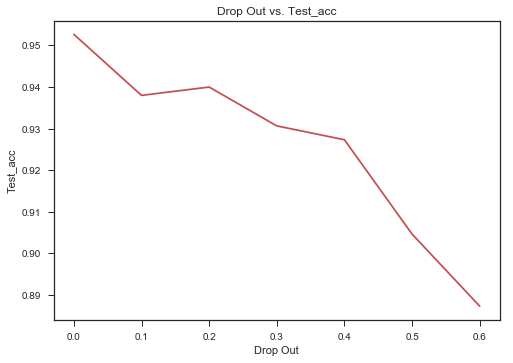

In [228]:
plt.plot(drop, test_acc, 'r-')
plt.xlabel('Drop Out')
plt.ylabel('Test_acc')
plt.title('Drop Out vs. Test_acc')

Discussion:
1. The highest test accuracy is 0.952 when there is no drop out(drop out = 0)
2. The test accuracy decreases when drop out percentage increases as the figure shows
3. The reasons are: first, the neural net is not deep, there are not too many parameters. Second, The input image do not have many features, only 400. Third, the drop out will increase the training speed for sure, but it will lose hidden layer features where drop out applied to. 
4. So based on the result, I think drop out is better to be applied to deeper neural networks and when the input has huge number of features. Besides, it is more suitable for CNN rather than MLP